In [1]:
#FULL DATA MINE AND CLEAN UP

#def getWeather():
import requests # library for html requests
from datetime import date # library for python date formats? *check*

#get weather
#set up daily link
weather_fcast = "http://www.metoffice.gov.uk/public/weather/forecast/gcpvj0v07"
#send url requests to data links
weather_fcast_rqst = requests.get(weather_fcast)
#convert web data to text strings
weather_fcast_text = weather_fcast_rqst.text
#for testing 
print(weather_fcast_text)

#def cleanWeather():
#clean weather
import numpy as np

weather_short = []

weather_date = weather_fcast_text.index('data-tab-id') #finds 1st date tabs within text string (should be today)
weather_fcast_chopped = weather_fcast_text #intialise weather dataframe

#counter for remaining days in week
days = 1
while days <= 7:

    weather_date_short=weather_fcast_chopped[weather_date+13:weather_date+23]

    #chop off the head of text string, find the max 
    weather_fcast_chopped = weather_fcast_chopped[weather_date:len(weather_fcast_chopped)]
    weather_max = weather_fcast_chopped.index('data-value-raw') #finds temp max within text string

    #find number of decimal places for max temp
    chr_adder=18
    while weather_fcast_chopped[weather_max+chr_adder] != '"':
        if chr_adder == 22:
            break
        chr_adder += 1

    weather_max_short=weather_fcast_chopped[weather_max+16:weather_max+chr_adder]

    #chop off the head of text string, find the min 
    weather_fcast_chopped = weather_fcast_chopped[weather_max+1:len(weather_fcast_chopped)]
    weather_min = weather_fcast_chopped.index('data-value-raw') #finds temp min within text string

    #find number of decimal places for max temp
    chr_adder=18
    while weather_fcast_chopped[weather_min+chr_adder] != '"':
        if chr_adder == 22:
            break
        chr_adder += 1

    weather_min_short=weather_fcast_chopped[weather_min+16:weather_min+chr_adder]

    #gather list data
    weather_short.append(days)
    weather_short[days-1]=[weather_date_short,weather_max_short,weather_min_short]

    #search the next occurence of the forecast date
    weather_fcast_chopped = weather_fcast_chopped[weather_min:len(weather_fcast_chopped)]
    weather_date = weather_fcast_chopped.index('data-tab-id') #finds date tabs within text string

    days += 1

#convert weather_short from list of lists to numpy array
weather_short = np.array(weather_short)

#get demand
import pandas as pd
data = pd.read_csv('https://api.bmreports.com/BMRS/FORDAYDEM/v1?APIKey=lg3cgfi7sanoqzm&ServiceType=csv', skiprows=[0])
print(data)

#clean demand

import datetime

data.columns = ['Demand Fcast Type', 'Date','Settlement Period','N Flag','Time of Fcast?', 'Demand MW']
load_fcast_text=data.filter(items=['Date','Settlement Period','Demand MW','Demand Fcast Type'])
load_fcast_text=load_fcast_text.loc[load_fcast_text['Demand Fcast Type'] == "DATF"]
load_fcast_text.set_index('Date')
print(load_fcast_text.dtypes)
load_fcast_text['Date'] = pd.to_datetime(load_fcast_text['Date'],format='%Y%m%d')

#convert load_fcast_text from list of lists to numpy array
load_fcast_text = np.array(load_fcast_text)
#print(load_fcast_text)

load_fcast_text_D=load_fcast_text[load_fcast_text[:,0] < datetime.datetime.now()]
load_fcast_text_D1=load_fcast_text[load_fcast_text[:,0] > datetime.datetime.now()]

print(load_fcast_text_D1)
#load_fcast_text_D+1

#print(load_fcast_text[:,2])
np.mean(load_fcast_text_D1[:,2])

#get RES
#NB skiprows below will skip number of rows specified and infer number of columns of data from the next row
#NB use str(date.today() + datetime.timedelta(1)) for tomorrow 
RES_data = pd.read_csv('https://api.bmreports.com/BMRS/B1440/v1?ServiceType=csv&Period=*&APIKey=lg3cgfi7sanoqzm&SettlementDate=' + str(date.today()), skiprows=4)
print(RES_data)
#USE THIS TO JUST PRINT ONE ROW: print(data.loc[1]) NB INDEXING STARTS FROM ROW ZERO WHICH IS FIRST ROW OF DATA (HEADER DOESNT COUNT)
#USE THIS TO JUST PRINT ONE VALUE WITHIN A ROW: print(data.iloc[1][5])

#clean RES
RES_fcast_text = RES_data[0:-1] #remove last row NaN
#no need to get column names, as these were imported with csv
RES_fcast_text=RES_fcast_text.filter(items=['Settlement Date','Settlement Period','Quantity ','Business Type','Power System Resource  Type'])
RES_fcast_text.set_index('Settlement Date') #may have to combine this later with settlement period
RES_fcast_text=RES_fcast_text.sort_values(by='Settlement Period')
RES_fcast_text=RES_fcast_text.reset_index(drop=True)
print(RES_fcast_text.dtypes)
#RES_fcast_text['Settlement Date'] = pd.to_datetime(RES_fcast_text['Settlement Date'],format='%Y%m%d')

#convert RES_fcast_text from list of lists to numpy array
RES_fcast_text = np.array(RES_fcast_text)

#print(RES_fcast_text)
print(RES_fcast_text[RES_fcast_text[:,0] == str(date.today())])

#get FX

import requests
FX = "https://www.poundsterlinglive.com/data/currencies/gbp-pairs/GBPEUR-exchange-rate"
FX_fcast_rqst = requests.get(FX)
print(FX_fcast_rqst) # should say 200 means connection is good
FX_fcast_text = FX_fcast_rqst.text
#print(FX_fcast_text)

#truncate data pulled back, from today's price
#first find "Today’s Price":
FX_GBPEUR = FX_fcast_text.index('Latest GBP/EUR') #find "Today’s Price" within data
#print(FX_EURGBP)
FX_GBPEUR_chopped=FX_fcast_text[FX_GBPEUR:len(FX_fcast_text)]

print(FX_GBPEUR_chopped)

#repeat for GBPUSD
FX = "https://www.poundsterlinglive.com/data/currencies/gbp-pairs/GBPUSD-exchange-rate"
FX_fcast_rqst = requests.get(FX)
print(FX_fcast_rqst) # should say 200 means connection is good
FX_fcast_text = FX_fcast_rqst.text
#print(FX_fcast_text)

#truncate data pulled back, from today's price
#first find "Today’s Price":
FX_GBPUSD = FX_fcast_text.index('Latest GBP/USD') #find "Today’s Price" within data

#print(FX_GBPUSD)
FX_GBPUSD_chopped=FX_fcast_text[FX_GBPUSD:len(FX_fcast_text)]

print(FX_GBPUSD_chopped)

#clean FX

FX_short = {}

FX_short[0,0]="GBPEUR"
FX_short[0,1]=FX_GBPEUR_chopped[45:51]
#NB can also store last 5, 10, 15, 20,50,100 days averages and % changes - later

FX_short[1,0]="GBPUSD"
FX_short[1,1]=FX_GBPUSD_chopped[45:51]

print(FX_short)
print(FX_short[0,1])
print(FX_short[1,1])

#get elec and gas prices
import pandas as pd
Marex_data = pd.read_csv('http://www.marexspectron.com/intelligence/indices/historical-index')
print(Marex_data)

#clean elec prices

#no need to get column names, as these were imported with csv
Marex_fcast_text=Marex_data.filter(items=['DealDate','Average','High','Low','IndexName','InstrumentName','SequenceItemName','MarketName'])
Marex_fcast_text.set_index('DealDate') 
#filter by elec baseload then by D-1
Marex_fcast_text=Marex_fcast_text.loc[(Marex_fcast_text['IndexName'] == "U.K Power BSLD All-Day D.A") | (Marex_fcast_text['IndexName'] == "U.K Power BSLD All-Day M.A") | (Marex_fcast_text['IndexName'] == "NBP All Day D.A") | (Marex_fcast_text['IndexName'] == "NBP All Day M.A") ]

Marex_fcast_text['DealDate'] = pd.to_datetime(Marex_fcast_text['DealDate'],format='%d/%m/%Y')

if date.today().weekday() == 0: #Monday
  Marex_fcast_text=Marex_fcast_text.loc[Marex_fcast_text['DealDate'] == date.today()- datetime.timedelta(3)] # NEED TO USE date.today()- timedelta(1))
else: #Tue, Wed, Thu or Fri. BASICALLY DONT RUN WEEKEND
  Marex_fcast_text=Marex_fcast_text.loc[Marex_fcast_text['DealDate'] == date.today()- datetime.timedelta(1)] # NEED TO USE date.today()- timedelta(1))

Marex_fcast_text=Marex_fcast_text.reset_index(drop=True) #reset index to 0

print(Marex_fcast_text.dtypes)
#RES_fcast_text['Settlement Date'] = pd.to_datetime(RES_fcast_text['Settlement Date'],format='%Y%m%d')

print(Marex_fcast_text)

Marex_fcast_text = np.array(Marex_fcast_text)

print(Marex_fcast_text)

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>

<meta name="eGMS.accessibility" content="A" />
<meta name="eGMS.subject.category" content="Climate and weather" />

<meta name="twitter:site" content="@metoffice" />
<meta name="twitter:card" content="summary" />
<meta name="twitter:url" content="https://www.metoffice.gov.uk/public/weather/forecast/gcpvj0v07" />

<meta property="fb:app_id" content="208580322593329" />
<meta property="og:site_name" content="Met Office" />

<meta property="og:type" content="website" />
<meta property="og:url" content="https://www.metoffice.gov.uk/public/weather/forecast/gcpvj0v07" />

<meta name="theme-color" content="#2a2a2a"/>

    <meta property="og:image" content="https://www.metoffice.gov.uk/webapp-assets/images/social-icons/default_card_315.jpg" />
    <meta property="twitter:image" content="https://www.metoffice.gov.uk/webapp-assets/images/social-icons/default_card_315.jpg" />

<meta property="og:image:width" content="315" />
<meta p

     DANF  20180815     1    N  20180814224500    22300
0    DANF  20180815   2.0    N    2.018081e+13  21435.0
1    DANF  20180815   3.0    N    2.018081e+13  20737.0
2    DANF  20180815   4.0    N    2.018082e+13  20400.0
3    DANF  20180815   5.0    N    2.018082e+13  20074.0
4    DANF  20180815   6.0    N    2.018082e+13  19784.0
5    DANF  20180815   7.0    N    2.018082e+13  19578.0
6    DANF  20180815   8.0    N    2.018082e+13  19492.0
7    DANF  20180815   9.0    N    2.018082e+13  19600.0
8    DANF  20180815  10.0    N    2.018082e+13  19881.0
9    DANF  20180815  11.0    N    2.018082e+13  20543.0
10   DANF  20180815  12.0    N    2.018082e+13  21162.0
11   DANF  20180815  13.0    N    2.018082e+13  23043.0
12   DANF  20180815  14.0    N    2.018082e+13  24740.0
13   DANF  20180815  15.0    N    2.018082e+13  27136.0
14   DANF  20180815  16.0    N    2.018082e+13  28758.0
15   DANF  20180815  17.0    N    2.018082e+13  29768.0
16   DANF  20180815  18.0    N    2.018082e+13  

<Response [200]>
Latest GBP/EUR Exchange Rate:</b>
</td>
<td>
1.1196 </td>
</tr>
<tr>
<td>
<b>Bid:</b>
</td>
<td>
1.1195 </td>
</tr>
<tr>
<td>
<b>Ask:</b>
</td>
<td>
1.1196 </td>
</tr>
<tr>
<td>
<b>Market Status:</b>
</td>
<td>
<span class='status green_color'>Live</span> </td>
</tr>
<tr>
<td>
<b>Percent Change:</b>
</td>
<td>
<span class='red_color'>-0.12%</span> </td>
</tr>
<tr>
<td>
<b>Today’s Open <span class="time_text">(00:01 GMT)</span>:</b>
</td>
<td>
1.1208
</td>
</tr>
<tr>
<td>
<b>Today’s High:</b>
</td>
<td>
1.1234 </td>
</tr>
<tr>
<td>
<b>Today’s Low:</b>
</td>
<td>
1.1192 </td>
</tr>
<tr>
<td>
<b>Previous day’s Close <span class="time_text">(23:59 GMT)</span>:</b>
</td>
<td>
1.1209 </td>
</tr>
<tr>
<td>
<b>Current Week High:</b>
</td>
<td>
1.1234 </td>
</tr>
<tr>
<td>
<b>Current Week Low:</b>
</td>
<td>
1.1166 </td>
</tr>
<tr>
<td>
<b>Current Month High:</b>
</td>
<td>
1.12914 </td>
</tr>
<tr>
<td>
<b>Current Month Low:</b>
</td>
<td>
1.10737 </td>
</tr>
</table>
</div>
<b

<Response [200]>
Latest GBP/USD Exchange Rate:</b>
</td>
<td>
1.2701 </td>
</tr>
<tr>
<td>
<b>Bid:</b>
</td>
<td>
1.27 </td>
</tr>
<tr>
<td>
<b>Ask:</b>
</td>
<td>
1.2701 </td>
</tr>
<tr>
<td>
<b>Market Status:</b>
</td>
<td>
<span class='status green_color'>Live</span> </td>
</tr>
<tr>
<td>
<b>Percent Change:</b>
</td>
<td>
<span class='red_color'>-0.1317%</span> </td>
</tr>
<tr>
<td>
<b>Today’s Open <span class="time_text">(00:01 GMT)</span>:</b>
</td>
<td>
1.2717
</td>
</tr>
<tr>
<td>
<b>Today’s High:</b>
</td>
<td>
1.2735 </td>
</tr>
<tr>
<td>
<b>Today’s Low:</b>
</td>
<td>
1.2662 </td>
</tr>
<tr>
<td>
<b>Previous day’s Close <span class="time_text">(23:59 GMT)</span>:</b>
</td>
<td>
1.2718 </td>
</tr>
<tr>
<td>
<b>Current Week High:</b>
</td>
<td>
1.2825 </td>
</tr>
<tr>
<td>
<b>Current Week Low:</b>
</td>
<td>
1.2662 </td>
</tr>
<tr>
<td>
<b>Current Month High:</b>
</td>
<td>
1.31436 </td>
</tr>
<tr>
<td>
<b>Current Month Low:</b>
</td>
<td>
1.2662 </td>
</tr>
</table>
</div>
<br

                           IndexName InstrumentName        SequenceItemName  \
0                  NBP All Day W/End            NBP          WEND 19-May-18   
1                NBP 1625-1635 W/End            NBP          WEND 19-May-18   
2                  NBP 1625-1635 D.A            NBP          D.A. 21-May-18   
3                    NBP All Day D.A            NBP          D.A. 21-May-18   
4                    NBP All Day M.A            NBP                  18-Jun   
5                  NBP 1600-1615 M.A            NBP                  18-Jun   
6                  NBP 1625-1635 D.A            NBP          D.A. 22-May-18   
7                    NBP All Day D.A            NBP          D.A. 22-May-18   
8                    NBP All Day M.A            NBP                  18-Jun   
9                  NBP 1600-1615 M.A            NBP                  18-Jun   
10                 NBP 1625-1635 D.A            NBP          D.A. 23-May-18   
11                   NBP All Day D.A            NBP 

In [2]:
#create neural network (live) input (i.e. test) and output (for valiation) matrices 

import numpy as np
import pandas as pd
import datetime

nn_input=0

#nn_input = np.array() #initialise

#nn=weather_short[0:2,1] #add weather highs
# print(weather_short[0:2,1])
# print(weather_short[0:2,2])
nn_input=np.concatenate((weather_short[:1,1], weather_short[:1,2])) #add high, weather low D NEEDS TWO BRACKETS (( ))
nn_input=np.concatenate((nn_input, weather_short[1:2,1])) #add high D+1
nn_input=np.concatenate((nn_input, weather_short[1:2,2])) #add low D+1
#nn_input stands for neural network and is input matrix, basically values for:

#WeatherHigh_D
#WeatherLow_D
#WeatherHigh_D+1
#WeatherLow_D+1
#Av Demand D
#Peak Demand D
#Av Demand D+1
#Peak Demand D+1
#Av Offshore Wind D
#Peak Offshore Wind D
#Av Onshore Wind D
#Peak Onshore Wind D
#Av Solar D
#Peak Solar D
#GBPEUR rate
#GBBUSD rate
#DA NBP 
#MA NBP

#add demand facast
nn_input=np.hstack((nn_input,round(np.mean(load_fcast_text_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(load_fcast_text_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(load_fcast_text_D1[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(load_fcast_text_D1[:,2]),2)))

#add RES fcast
#RES_fcast_D=RES_fcast_text[RES_fcast_text[:,0] == str(date.today())])

RES_fcast_D= RES_fcast_text[RES_fcast_text[:,0] == str(date.today())]
OFFwind_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Wind Offshore']
ONwind_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Wind Onshore']
SolarPV_fcast_D=RES_fcast_D[RES_fcast_D[:,4] == 'Solar']
nn_input=np.hstack((nn_input,round(np.mean(OFFwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(OFFwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(ONwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(ONwind_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.mean(SolarPV_fcast_D[:,2]),2)))
nn_input=np.hstack((nn_input,round(np.max(SolarPV_fcast_D[:,2]),2)))

#print(RES_fcast_D)
#load_fcast_text[load_fcast_text[:,0] < datetime.datetime.now()]

#add FX fcast
nn_input=np.hstack((nn_input,FX_short[0,1])) #GBPEUR
nn_input=np.hstack((nn_input,FX_short[1,1])) #GBPUSD

#add NBP prices
nn_input=np.hstack((nn_input,Marex_fcast_text[:1,1])) #DA NBP
nn_input=np.hstack((nn_input,Marex_fcast_text[1:2,1])) #MA NBP

#add Marex elec prices
nn_input=np.hstack((nn_input,Marex_fcast_text[2:3,1])) #DA elec
nn_input=np.hstack((nn_input,Marex_fcast_text[3:4,1])) #MA elec

#create nn_output (predictor is Marex elec price)
#NB need to update later - this is the target, so the forecast is not "known" until D+a
#nn_output=np.concatenate((Marex_fcast_text[2:3,1], Marex_fcast_text[3:4,1]))
#nn_output stands for neural network and is output (target) matrix, basically values for:

#DA elec
#MA elec

#nn_input=np.asarray(np.mean(load_fcast_text_D[:,2]))
print(nn_input)
#print(nn_output)

#np.savetxt('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv', nn_input, fmt='%s', delimiter=',', header="WeatherHigh_D,WeatherLow_D,WeatherHigh_D+1,WeatherLow_D+1,Av Demand D,Peak Demand D,Av Demand D+1,Peak Demand D+1,Av Offshore Wind D,Peak Offshore Wind D,Av Onshore Wind D,Peak Onshore Wind D,Av Solar D,Peak Solar D,GBPEUR rate,GBBUSD rate,DA NBP,MA NBP")

#convert neural network input to pandas data frame
nn_input=pd.DataFrame(nn_input,columns = [str(date.today())])
print(str(date.today()))
nn_input=nn_input.T #transpose array for csv export

#USE TWO LINES BELOW ONCE THIS IS UP AND RUNNING TO APPEND DATA
with open('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv', 'a') as rolling_training_data:
    nn_input.to_csv(rolling_training_data,header=False, index=True)
#nn_input.to_csv("C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv", index = False, header= False)

['24.53' '17.22' '19.62' '13.4' '27973.52' '32393.0' '26848.76' '32288.0'
 '2453.72' '3728.65' '5186.92' '6998.81' '1350.48' '3848.0' '1.1196'
 '1.2701' '61.6573034' '62.7656463' '59.75' '61.8185714']
2018-08-15


In [3]:
#training data set - THIS IS THE CONTINUALLY UPDATING DAILY DATA FILE

import pandas as pd
training_data = pd.read_csv('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv',index_col=[0])
#training_data.set_index("Date", drop = True)
print(training_data)

training_data=np.array(training_data) #turn training_data pandas dataframe into numpy array for NN algo

            WeatherHigh_D  WeatherLow_D  WeatherHigh_D+1  WeatherLow_D+1  \
01/07/2018      31.666667     15.000000        30.000000       18.333333   
02/07/2018      30.000000     18.333333        27.222222       15.000000   
03/07/2018      27.222222     15.000000        26.666667       13.888889   
04/07/2018      26.666667     13.888889        30.000000       16.666667   
05/07/2018      30.000000     16.666667        30.555556       16.111111   
06/07/2018      30.555556     16.111111        31.111111       18.333333   
07/07/2018      31.111111     18.333333        30.555556       17.222222   
08/07/2018      30.555556     17.222222        30.000000       17.777778   
09/07/2018      30.000000     17.777778        22.777778       15.000000   
10/07/2018      22.777778     15.000000        23.888889       13.888889   
11/07/2018      23.888889     13.888889        25.000000       13.333333   
12/07/2018      25.000000     13.333333        26.666667       15.555556   
13/07/2018  

In [4]:
#plot training data as time series plots
#see for help: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

from pandas import read_csv
from matplotlib import pyplot

#input('Starting python')

# load dataset
dataset = read_csv('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
i = 1
# plot each column
pyplot.figure(0)
# pyplot.figure(figsize=(8,20)) # have to comment out for running python shell as will cause an error trying to fit plot to window
for group in groups:  
	pyplot.subplot(len(groups), 1, i) #subplot(nrows, ncols, index, **kwargs)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=-0.05, loc='right')
	i += 1
pyplot.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1, wspace=0.2, hspace=0.1)
pyplot.show()

#taken from https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
pyplot.figure(1)
pyplot.matshow(dataset.corr())
pyplot.show() #required to show plot when running python shell

#input('End of code')

C:\Users\barry.walsh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[0.8935946  0.28199995 0.8193697  0.6227467  0.         0.10463428
  0.7305722  0.7994752  1.         0.99549276 0.57723343 0.497652
  0.86256504 0.73474854 0.8170204  0.8552189  0.         0.
  0.         0.        ]
 [0.7882428  0.6153333  0.6058587  0.29498518 0.54261184 0.6460519
  0.75079083 0.7693429  0.4523349  0.6053543  0.26651004 0.19229165
  1.         1.         0.7446785  0.7441082  0.         0.
  0.         0.        ]
 [0.61265624 0.28199995 0.5631565  0.18573141 0.5641463  0.5959954
  0.9169185  0.8697512  0.5562012  0.64244413 0.27230257 0.27597183
  0.97089505 0.7920446  0.85532    0.8282852  0.13010883 0.
  0.22976732 0.23115301]
 [0.57753897 0.1708889  0.8193697  0.45886588 0.7410848  0.7627969
  0.9163239  0.8256221  0.11339145 0.3155254  0.08230594 0.16669855
  0.48868787 0.36768347 1.         0.89562416 0.37537003 0.19108295
  0.8117871  0.26498032]
 [0.7882428  0.44866657 0.8620719  0.40423894 0.7404516  0.6894884
  0.8551631  0.7944207  0.06128865 0.11405357 

Train on 33 samples, validate on 9 samples
Epoch 1/50
 - 5s - loss: 0.5149 - val_loss: 0.5665
Epoch 2/50
 - 0s - loss: 0.4890 - val_loss: 0.5383
Epoch 3/50
 - 0s - loss: 0.4631 - val_loss: 0.5100
Epoch 4/50
 - 0s - loss: 0.4372 - val_loss: 0.4819
Epoch 5/50
 - 0s - loss: 0.4114 - val_loss: 0.4536
Epoch 6/50
 - 0s - loss: 0.3856 - val_loss: 0.4253
Epoch 7/50
 - 0s - loss: 0.3596 - val_loss: 0.3968
Epoch 8/50
 - 0s - loss: 0.3335 - val_loss: 0.3682
Epoch 9/50
 - 0s - loss: 0.3076 - val_loss: 0.3394
Epoch 10/50
 - 0s - loss: 0.2828 - val_loss: 0.3105
Epoch 11/50
 - 0s - loss: 0.2587 - val_loss: 0.2814
Epoch 12/50
 - 0s - loss: 0.2359 - val_loss: 0.2522
Epoch 13/50
 - 0s - loss: 0.2156 - val_loss: 0.2234
Epoch 14/50
 - 0s - loss: 0.2029 - val_loss: 0.1956
Epoch 15/50
 - 0s - loss: 0.1936 - val_loss: 0.1715
Epoch 16/50
 - 0s - loss: 0.1864 - val_loss: 0.1596
Epoch 17/50
 - 0s - loss: 0.1818 - val_loss: 0.1522
Epoch 18/50
 - 0s - loss: 0.1799 - val_loss: 0.1495
Epoch 19/50
 - 0s - loss: 0.17

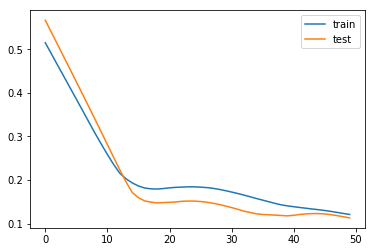

[57.4      56.85     57.036667 60.       61.818573 56.765385 55.850002
 56.75     58.945538] [56.729237 56.324852 57.589035 56.70567  59.624146 56.981876 55.54125
 56.561024 57.856583]
Test RMSE: 1.417


In [5]:
#Multivariate Time Series Forecasting with LSTMs in Keras

import numpy as np
import math

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('C:\ChangingEnergy\Beta_testing\ML testing\RollingTrainingData.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4]) #assigns ordinal levels to categorical data - this is for label data dont need in our case

# ensure all data is float
values = values.astype('float32')
#print(values)
#print("BREAK")
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict - this is basically all columns for predictor variables at t+1 (next time step)
reframed.drop(reframed.columns[[20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_train_days = math.floor(len(values)*0.8) #use 80/20 rule train on 80% of data, test on 20%
np.random.shuffle(values) #shuffling data to remove trend (will randomly assign test data and training data rather than take 
#e.g. first 80 days to train on and last 20 days to test on - if its a rising market this is likely to underfit)
train = values[:n_train_days, :] 
test = values[n_train_days:, :] 
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1] #stick with MA elec for now, later expand to DA and MA if code scalable
test_X, test_y = test[:, :-1], test[:, -1] #stick with MA elec for now, later expand to DA and MA if code scalable

# reshape input to be 3D [samples, timesteps, features]
print(train_X)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network #check batch size should be big really (assuming big data sourced). 
#In our case its still a small growing dataset, example used batch size 72 and epochs 50
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)

In [6]:
#latest predictor dataset only
import datetime
import numpy as np
import pandas as pd

#first read existing forecast v. actual file to get deltas
forecast_comparison = pd.read_csv('C:\ChangingEnergy\Beta_testing\ML testing\Elec_MA_fcast.csv',index_col=[0])
#forecast_comparison.set_index("Date", drop = False)

forecast_comparison=np.array(forecast_comparison) #turn training_data pandas dataframe into numpy array for NN algo

#get latest deltas
latest_actual_delta= [float(Marex_fcast_text[3:4,1]) - forecast_comparison[len(forecast_comparison)-1,0]] #latest actual delta
latest_fcast_delta=[forecast_comparison[len(forecast_comparison)-1,1] - forecast_comparison[len(forecast_comparison)-2,1]] #latest forecast delta

latest_data= series_to_supervised(scaled, 0, 1) #no time increment for last row of predictor variables as forecast is "unknown"
values=latest_data.values
latest_X=values[len(values)-1:, :]
print(latest_X.shape)
print(latest_X[:,-1].shape)

#reshape input to be 3D [samples, timesteps, features]
latest_X = latest_X.reshape((latest_X.shape[0], 1, latest_X.shape[1]))
print(latest_X.shape)
# latest_X
# latest_X = latest_X.reshape((latest_X.shape[0], latest_X.shape[2]))
# latest_X=scaler.inverse_transform(latest_X)
# latest_X


# make a prediction
latest_hat = model.predict(latest_X)

#get ready to transform back
latest_X = latest_X.reshape((latest_X.shape[0], latest_X.shape[2]))
# invert scaling for forecast
inv_latest_hat = concatenate((latest_X[:, :-1],latest_hat), axis=1)
inv_latest_hat = scaler.inverse_transform(inv_latest_hat)
print(inv_latest_hat) #check this should be the latest predictor varables (20) minus last elec MA price plus a single forecasted MA price at end of array
inv_latest_hat = inv_latest_hat[:,-1]

#export latest forecast to csv

latest_forecast=concatenate((Marex_fcast_text[3:4,1],inv_latest_hat,latest_actual_delta,latest_fcast_delta), axis=0)

print(Marex_fcast_text[3:4,1])
print(latest_forecast)
#convert forecast to pandas data frame
latest_forecast=pd.DataFrame(latest_forecast,columns = [str(date.today())])
print(str(date.today()))
print(latest_forecast)
latest_forecast=latest_forecast.T #transpose array for csv export

with open('C:\ChangingEnergy\Beta_testing\ML testing\Elec_MA_fcast.csv', 'a') as rolling_forecast:
    latest_forecast.to_csv(rolling_forecast,header=False, index=True)

(1, 20)
(1,)
(1, 1, 20)
[[2.4530001e+01 1.7219999e+01 1.9620001e+01 1.3399999e+01 2.7973521e+04
  3.2393000e+04 2.6848760e+04 3.2288000e+04 2.4537200e+03 3.7286499e+03
  5.1869199e+03 6.9988101e+03 1.3504800e+03 3.8480000e+03 1.1196001e+00
  1.2701000e+00 6.1657299e+01 6.2765648e+01 5.9750000e+01 5.9659859e+01]]
['61.8185714']
['61.8185714' 59.65985870361328 0.0 0.4733543395996094]
2018-08-15
   2018-08-15
0  61.8185714
1     59.6599
2           0
3    0.473354
